In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import skew

%matplotlib inline

Import Data
======

In [138]:
house_train = pd.read_csv("/home/aeb/Documents/mlproj/mlproj/train.csv")
house_test = pd.read_csv("/home/aeb/Documents/mlproj/mlproj/test.csv")
house_all = pd.concat((house_train, house_test))

Data Preprocessing and Cleaning
===============================

Filling in Missing Values
-----------------------------

Figure out which columns are numerical and which are categorical

In [139]:
numerical_features = house_all.select_dtypes(include=["float", "int", "bool"]).columns.values
categorical_features = house_all.select_dtypes(include=["object"]).columns.values

In [140]:
print(numerical_features, "\n\n", categorical_features)

['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'BedroomAbvGr' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtFullBath' 'BsmtHalfBath' 'BsmtUnfSF' 'EnclosedPorch' 'Fireplaces'
 'FullBath' 'GarageArea' 'GarageCars' 'GarageYrBlt' 'GrLivArea' 'HalfBath'
 'Id' 'KitchenAbvGr' 'LotArea' 'LotFrontage' 'LowQualFinSF' 'MSSubClass'
 'MasVnrArea' 'MiscVal' 'MoSold' 'OpenPorchSF' 'OverallCond' 'OverallQual'
 'PoolArea' 'SalePrice' 'ScreenPorch' 'TotRmsAbvGrd' 'TotalBsmtSF'
 'WoodDeckSF' 'YearBuilt' 'YearRemodAdd' 'YrSold'] 

 ['Alley' 'BldgType' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'BsmtQual' 'CentralAir' 'Condition1' 'Condition2' 'Electrical' 'ExterCond'
 'ExterQual' 'Exterior1st' 'Exterior2nd' 'Fence' 'FireplaceQu' 'Foundation'
 'Functional' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'Heating' 'HeatingQC' 'HouseStyle' 'KitchenQual' 'LandContour' 'LandSlope'
 'LotConfig' 'LotShape' 'MSZoning' 'MasVnrType' 'MiscFeature'
 'Neighborhood' 'PavedDrive' 'PoolQC' 'RoofMatl' 'RoofStyle'
 'SaleConditi

Fill in some missing values (mostly categorical), modified from technique described here:

https://www.kaggle.com/klyusba/lasso-model-for-regression-problem 

In [129]:
house_all.loc[house_all.Alley.isnull(), 'Alley'] = 'NoAlley'
house_all.loc[house_all.MasVnrType.isnull(), 'MasVnrType'] = 'None' # no good
house_all.loc[house_all.MasVnrType == 'None', 'MasVnrArea'] = 0
house_all.loc[house_all.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
house_all.loc[house_all.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
house_all.loc[house_all.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
house_all.loc[house_all.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
house_all.loc[house_all.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'
house_all.loc[house_all.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
house_all.loc[house_all.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
house_all.loc[house_all.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = house_all.BsmtFinSF1.median()
house_all.loc[house_all.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
house_all.loc[house_all.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = house_all.BsmtUnfSF.median()
house_all.loc[house_all.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0
house_all.loc[house_all.FireplaceQu.isnull(), 'FireplaceQu'] = 'NoFireplace'
house_all.loc[house_all.GarageType.isnull(), 'GarageType'] = 'NoGarage'
house_all.loc[house_all.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'
house_all.loc[house_all.GarageQual.isnull(), 'GarageQual'] = 'NoGarage'
house_all.loc[house_all.GarageCond.isnull(), 'GarageCond'] = 'NoGarage'
house_all.loc[house_all.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
house_all.loc[house_all.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0
house_all.loc[house_all.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
house_all.loc[house_all.MSZoning.isnull(), 'MSZoning'] = 'RL'
house_all.loc[house_all.Utilities.isnull(), 'Utilities'] = 'AllPub'
house_all.loc[house_all.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
house_all.loc[house_all.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
house_all.loc[house_all.Functional.isnull(), 'Functional'] = 'Typ'
house_all.loc[house_all.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
house_all.loc[house_all.SaleCondition.isnull(), 'SaleType'] = 'WD'
house_all.loc[house_all['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'
house_all.loc[house_all['Fence'].isnull(), 'Fence'] = 'NoFence'
house_all.loc[house_all['MiscFeature'].isnull(), 'MiscFeature'] = 'None'
house_all.loc[house_all['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
# only one is null and it has type Detchd
house_all.loc[house_all['GarageArea'].isnull(), 'GarageArea'] = house_all.loc[house_all['GarageType']=='Detchd', 'GarageArea'].mean()
house_all.loc[house_all['GarageCars'].isnull(), 'GarageCars'] = house_all.loc[house_all['GarageType']=='Detchd', 'GarageCars'].median()
# only one is null, guess it is the most common option WD
house_all.loc[house_all['SaleType'].isnull(), 'SaleType'] = 'WD'
house_all.loc[house_all['LotFrontage'].isnull(), 'LotFrontage'] = house_all.LotFrontage.median()

In [130]:
house_all.loc[house_all['GarageYrBlt'].isnull(), 'GarageYrBlt'] = house_all.loc[house_all['GarageYrBlt'].isnull(), 'YearBuilt']

Fill any remaining missing numerical values with mean of column

In [7]:
house_all = house_all.fillna(house_all.mean())

In [141]:
missing = house_all.isnull().sum()
missing[missing != 0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

Transform Skewed Variables
--------------------------

Find the numerical columns whose skewness exceeds a set threshold, and transform them by taking y = log(x + 1)

In [8]:
house_train[numerical_features].apply(lambda x: skew(x.dropna()))

1stFlrSF          1.375342
2ndFlrSF          0.812194
3SsnPorch        10.293752
BedroomAbvGr      0.211572
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
BsmtUnfSF         0.919323
EnclosedPorch     3.086696
Fireplaces        0.648898
FullBath          0.036524
GarageArea        0.179796
GarageCars       -0.342197
GarageYrBlt      -0.648708
GrLivArea         1.365156
HalfBath          0.675203
Id                0.000000
KitchenAbvGr      4.483784
LotArea          12.195142
LotFrontage       2.160866
LowQualFinSF      9.002080
MSSubClass        1.406210
MasVnrArea        2.666326
MiscVal          24.451640
MoSold            0.211835
OpenPorchSF       2.361912
OverallCond       0.692355
OverallQual       0.216721
PoolArea         14.813135
SalePrice         1.880941
ScreenPorch       4.117977
TotRmsAbvGrd      0.675646
TotalBsmtSF       1.522688
WoodDeckSF        1.539792
YearBuilt        -0.612831
YearRemodAdd     -0.503044
Y

In [9]:
SKEWNESS_CUTOFF = 0.75

skewed_features = house_train[numerical_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > SKEWNESS_CUTOFF]
skewed_features = skewed_features.index

house_all[skewed_features] = np.log1p(house_all[skewed_features])

In [142]:
skewed_features

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea',
       'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass',
       'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'SalePrice',
       'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF'],
      dtype='object')

Convert Categorical Variables to Dummies
----------------------------------------------

In [10]:
house_all = pd.get_dummies(house_all)

Split back up into test and training data, drop "SalePrice" column from both but save it separately for training data

Split Back Into Test and Train
----------------------------------

In [11]:
train_data = house_all[:house_train.shape[0]]
test_data = house_all[house_train.shape[0]:]

test_data = test_data.drop('SalePrice', axis=1)
train_vals = train_data.SalePrice
train_data = train_data.drop('SalePrice', axis=1)

Model Testing
=======

Ridge Regression
------------------

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

Define a function which does cross validation on the training data by splitting it into 5 segments

In [13]:
def rmse_crossval(model):
    return np.sqrt(-cross_val_score(model,
                                    train_data,
                                    train_vals,
                                    scoring="neg_mean_squared_error",
                                    cv = 5))

Try varying values of alpha and plot the RMSE from cross-validation.  Alpha = 10 is best.

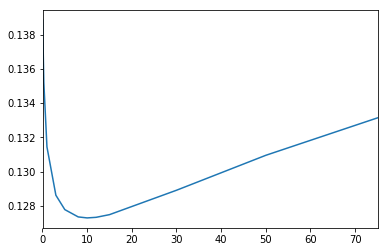

In [14]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 8, 10, 12, 15, 30, 50, 75]
ridges = [rmse_crossval(Ridge(alpha = alpha)).mean() for alpha in alphas]

pd.Series(ridges, index = alphas).plot()

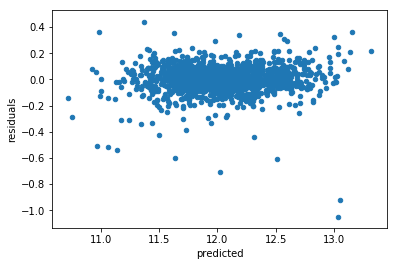

In [15]:
ridge_model = Ridge(alpha = 10)
predicted_vals = ridge_model.fit(train_data, train_vals).predict(train_data)
pd.DataFrame({"predicted": predicted_vals,
              "residuals": train_vals - predicted_vals}).plot(x="predicted", y="residuals", kind="scatter")


Lasso Model
-----------

In [16]:
lalphas = [1, 0.1, 0.001, 0.0005, 0.0001, 0.00005]
lasso_model = LassoCV(alphas = lalphas).fit(train_data, train_vals)

In [17]:
coef = pd.Series(lasso_model.coef_, index = train_data.columns)

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 114 variables and eliminated the other 189 variables


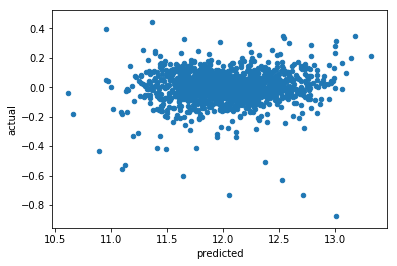

In [19]:
pd.DataFrame({"predicted": lasso_model.predict(train_data),
              "actual": train_vals - lasso_model.predict(train_data)}).plot(x="predicted", y="actual", kind="scatter")

In [125]:
abs(coef).sort_values()
print(coef)

1stFlrSF                 0.032557
2ndFlrSF                -0.003095
3SsnPorch                0.002112
BedroomAbvGr            -0.000732
BsmtFinSF1               0.009273
BsmtFinSF2              -0.001548
BsmtFullBath             0.026200
BsmtHalfBath             0.000000
BsmtUnfSF               -0.004098
EnclosedPorch            0.003110
Fireplaces               0.015933
FullBath                 0.021242
GarageArea               0.000045
GarageCars               0.039113
GarageYrBlt              0.000190
GrLivArea                0.396447
HalfBath                 0.013890
Id                      -0.000009
KitchenAbvGr            -0.010566
LotArea                  0.072012
LotFrontage              0.000000
LowQualFinSF            -0.004012
MSSubClass              -0.008162
MasVnrArea              -0.000249
MiscVal                 -0.002919
MoSold                  -0.000654
OpenPorchSF              0.001691
OverallCond              0.043253
OverallQual              0.052984
PoolArea      

Support Vector Regression
-------------------------

In [21]:
from sklearn.svm import SVR

In [22]:
svr_model = SVR(epsilon=0.01)
svr_model.fit(train_data, train_vals).predict(train_data)

array([ 12.23771285,  12.09899609,  12.30705582, ...,  12.48319637,
        11.87449455,  11.91164323])

0.398677219498


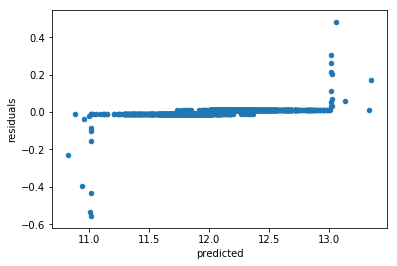

In [60]:
svr_predictions = svr_model.fit(train_data, train_vals).predict(train_data)

print(rmse_crossval(svr_model).mean())

pd.DataFrame({"predicted": svr_predictions,
              "residuals": train_vals - svr_predictions}).plot(x="predicted",
                                                               y="residuals",
                                                               kind="scatter")

In [47]:
rmse_crossval(svr_model)

array([ 0.38641219,  0.4244922 ,  0.40980822,  0.38132644,  0.39134704])

Random Forest
-------------

In [24]:
from sklearn.ensemble import RandomForestRegressor

Mean RSME:  0.153698315367


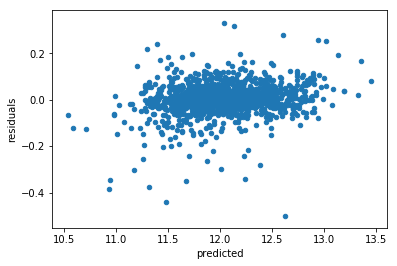

In [53]:
rf = RandomForestRegressor(n_estimators=10)
rf_predictions = rf.fit(train_data, train_vals).predict(train_data)

print("Mean RSME: ", rmse_crossval(rf).mean())

pd.DataFrame({"predicted": rf_predictions,
              "residuals": train_vals - rf_predictions}).plot(x="predicted", y="residuals", kind="scatter")

XGBoost
-------

In [32]:
from xgboost.sklearn import XGBRegressor

Mean RSME:  0.129364246364


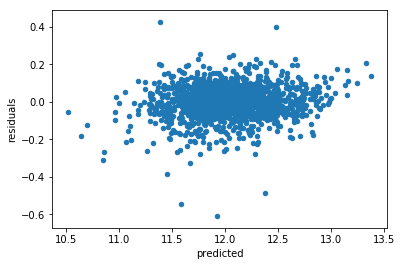

In [54]:
xgb = XGBRegressor()
xg_predictions = xgb.fit(train_data, train_vals).predict(train_data)

print("Mean RSME: ", rmse_crossval(xgb).mean())

pd.DataFrame({"predicted": xg_predictions,
              "residuals": train_vals - xg_predictions}).plot(x="predicted", y="residuals", kind="scatter")

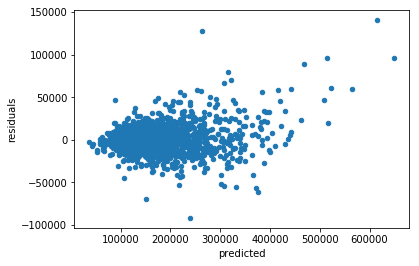

In [63]:
pd.DataFrame({"predicted": np.expm1(xg_predictions),
              "residuals": np.expm1(train_vals) - np.expm1(xg_predictions)}).plot(x="predicted", y="residuals", kind="scatter")

In [61]:
skewed_features

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea',
       'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass',
       'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'SalePrice',
       'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF'],
      dtype='object')